# Task 9

*Important note: Please run this notebook in strict sequential order. If you re-run individual cells that co-use variables, the computation might fail or could be incorrect due to the large number of similar data sets that are included in the task!*

*Please also note: Due to a bug in Google Colab, this notebook sometimes loses its cell output. There is no workaround, as this is related to notebook-uploads that don’t work correctly for some accounts. If you need pre-computed outputs and if this notebook shouldn’t include them, please check our identical copy of the file in our SCC-Gitlab-Repository under https://git.scc.kit.edu/ubelj/psda-group-4/-/tree/master/submission-1*


Task 9 deals with predicitive maintainance and engine simulations as a data source for preicitve models.  

# Mount Google Drive

The data is saved in the folder of personal Google drive.

In [12]:
from google.colab import drive
drive.mount('/content/drive')

# Install Python Packages

In [13]:
!pip install tsfresh
# tsfresh is a python package, which automatically calculates a large number of time series characteristics (features)

# Import Packages

In [14]:
import pandas as pd
import seaborn as sns
import numpy as np
sns.set()
import matplotlib.pyplot as plt
plt.rcParams['ytick.labelsize'] = "x-large"
plt.rcParams['xtick.labelsize'] = "x-large"
plt.rcParams['axes.labelsize'] = "x-large"
plt.rcParams['figure.titlesize'] = "x-large"


from sklearn.preprocessing import normalize

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error

# Data Description
C-MAPSS data set which contains turbofan engine degradation data is a widely used prognostic benchmark data for predicting the Remaining useful life (RUL). This data set is simulated by the tool Commercial Modular Aero Propulsion System Simulation (C-MAPSS) developed by NASA. Run to failure simulations were performed for engines with varying degrees of initial wear but in a healthy state. During each cycle in the simulation, one sample of all 21 sensors such as physical core speed, temperature at fan inlet and pressure at fan inlet etc will be recorded once. As the simulation progresses, the performance of the turbofan engine degrades until it loses functionality. 

C-MAPSS data consists of four sub-data sets with different operational conditions and fault patterns. 

|         Dataset        | FD001 | FD002 | FD003 | FD004 |
|:----------------------:|:-----:|:-----:|:-----:|:-----:|
|      Training set      |  100  |  260  |  100  |  249  |
|        Test set        |  100  |  259  |  100  |  248  |
| Operational conditions |   1   |   6   |   1   |   6   |
| Fault conditions       | 1     | 1     | 2     | 2     |


As shown Table above, each sub-data set has been split into a training set and a test set. The training sets contain sensor records for all cycles in the run to failure simulation. Unlike the training sets, the test sets only contain partial temporal sensor records which stopped at a time prior to the failure. The task is to predict the RUL of each engine in the test sets by using the training sets with the given sensor records. The corresponding RUL to test sets has been provided. With this, the performance of the model can be verified. 

The data provieded as text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

unit number

time, in cycles

operational setting 1

operational setting 2

operational setting 3

sensor measurement 1

sensor measurement 2 

sensor measurement 3 

...

sensor measurement 26

# Data Exploration and Preparation
take FD001 as example

In [15]:
# Load the Data
Path_to_data = "drive/My Drive/CMAPSSData/"

column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']
# training data set
train_FD001 = pd.read_table(Path_to_data+"train_FD001.txt", header=None, delim_whitespace=True)
train_FD001.columns = column_name

# test data set
test_FD001 = pd.read_table(Path_to_data+"test_FD001.txt", header=None, delim_whitespace=True)
test_FD001.columns = column_name

# RUL for test data set
RUL_FD001 = pd.read_table(Path_to_data+"RUL_FD001.txt", header=None, delim_whitespace=True)

train_FD001.head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In this sub dataset we have **100** engines (engine_id) which are monitored over time (cycle). Each engine had operational_settings and sensor_measurements recorded for each cycle. The RUL is the amount of cycles an engine has left before it needs maintenance. What makes this data set special is that the engines run all the way until failure, giving us precise RUL information for every engine at every point in time.

In [16]:
def add_RUL(col):
    # Reverse the cycle evolution, where remaining time of a machine is 0 at the failure.
    # It is assumed here that the state of the machine is linearly deteriorating
    return col[::-1]-1
# Calculate RUL for each time point of each engine  
train_FD001['rul'] = train_FD001[['engine_id', 'cycle']].groupby('engine_id').transform(add_RUL)

We are also going to load and explore the other three data sets available now.

In [17]:
train_FD002 = pd.read_table(Path_to_data+"train_FD002.txt", header=None, delim_whitespace=True)
train_FD002.columns = column_name
RUL_FD002 = pd.read_table(Path_to_data+"RUL_FD002.txt", header=None, delim_whitespace=True)
train_FD002['rul'] = train_FD002[['engine_id', 'cycle']].groupby('engine_id').transform(add_RUL)

test_FD002 = pd.read_table(Path_to_data+"test_FD002.txt", header=None, delim_whitespace=True)
test_FD002.columns = column_name

train_FD003 = pd.read_table(Path_to_data+"train_FD003.txt", header=None, delim_whitespace=True)
train_FD003.columns = column_name
RUL_FD003 = pd.read_table(Path_to_data+"RUL_FD003.txt", header=None, delim_whitespace=True)
train_FD003['rul'] = train_FD003[['engine_id', 'cycle']].groupby('engine_id').transform(add_RUL)

test_FD003 = pd.read_table(Path_to_data+"test_FD003.txt", header=None, delim_whitespace=True)
test_FD003.columns = column_name

train_FD004 = pd.read_table(Path_to_data+"train_FD004.txt", header=None, delim_whitespace=True)
train_FD004.columns = column_name
RUL_FD004 = pd.read_table(Path_to_data+"RUL_FD004.txt", header=None, delim_whitespace=True)
train_FD004['rul'] = train_FD004[['engine_id', 'cycle']].groupby('engine_id').transform(add_RUL)

test_FD004 = pd.read_table(Path_to_data+"test_FD004.txt", header=None, delim_whitespace=True)
test_FD004.columns = column_name

Let’s start with visualizing intersting aspects to start out.

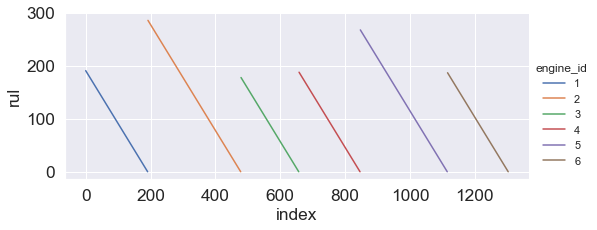

In [18]:
# Visualize the RUL curve of some engines (1,2,3,4,5,6)
g = sns.PairGrid(data=train_FD001.reset_index().query('engine_id < 7') ,
                 x_vars=["index"],
                 y_vars=['rul'],
                 hue="engine_id", height=3, aspect=2.5)

g = g.map(plt.plot, alpha=1)
g = g.add_legend()

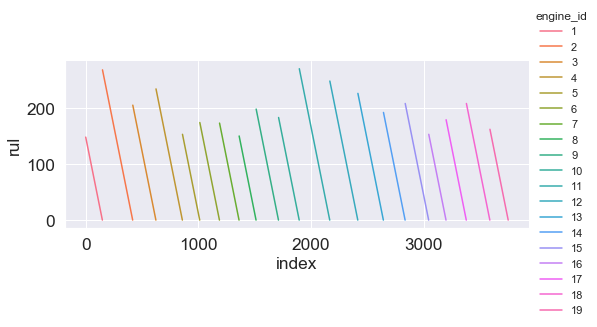

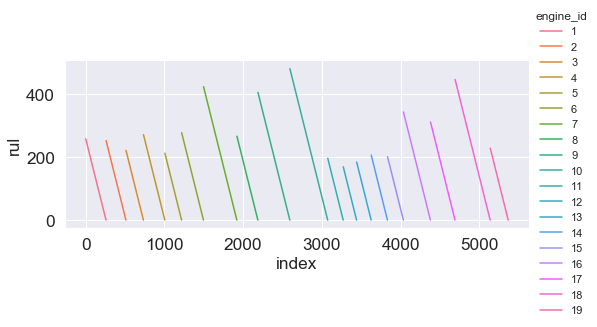

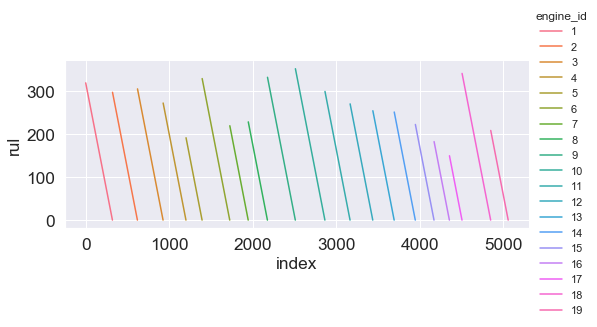

In [19]:
# So the same for the other training data sets avaiable, look at more engines
g1 = sns.PairGrid(data=train_FD002.reset_index().query('engine_id < 20') ,
                 x_vars=["index"],
                 y_vars=['rul'],
                 hue="engine_id", height=3, aspect=2.5)

g1 = g1.map(plt.plot, alpha=1)
g1 = g1.add_legend()

g2 = sns.PairGrid(data=train_FD003.reset_index().query('engine_id < 20') ,
                 x_vars=["index"],
                 y_vars=['rul'],
                 hue="engine_id", height=3, aspect=2.5)

g2 = g2.map(plt.plot, alpha=1)
g2 = g2.add_legend()

g3 = sns.PairGrid(data=train_FD004.reset_index().query('engine_id < 20') ,
                 x_vars=["index"],
                 y_vars=['rul'],
                 hue="engine_id", height=3, aspect=2.5)

g3 = g3.map(plt.plot, alpha=1)
g3 = g3.add_legend()

From these plots, we can at least qualitatively get a first impression that tells us that all four traing data sets are of similar kind and no clear outliers on a data set level exist.

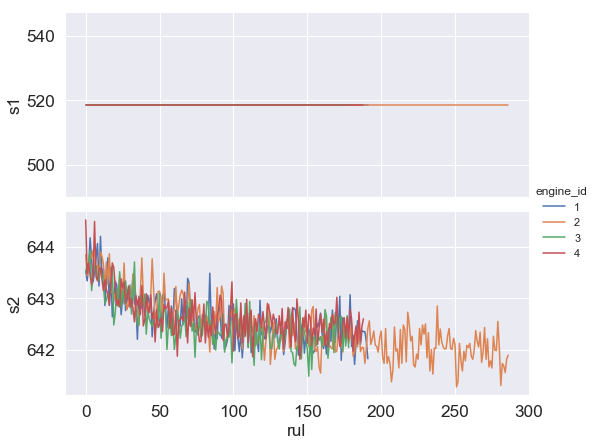

In [20]:
# Visualize some sensor curves of some engines 
g = sns.PairGrid(data=train_FD001.query('engine_id < 5') ,
                 x_vars=["rul"],
                 y_vars=['s1','s2'],
                 hue="engine_id", height=3, aspect=2.5)

g = g.map(plt.plot, alpha=1)
g = g.add_legend()

# As shown in the figure, some sensors are not related to RUL. 
# The values of some sensors change with the state of the machine. 
# Visualization can help filter features

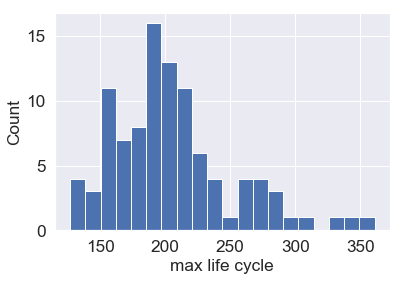

In [21]:
# Distribution of maximum life cycle
train_FD001[['engine_id', 'rul']].groupby('engine_id').apply(np.max)["rul"].hist(bins=20)
plt.xlabel("max life cycle")
plt.ylabel("Count")
plt.show()

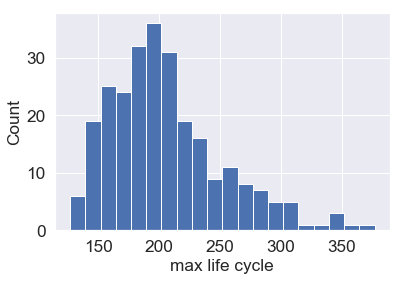

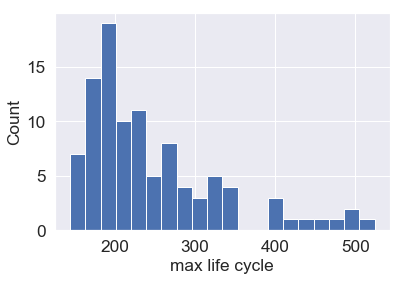

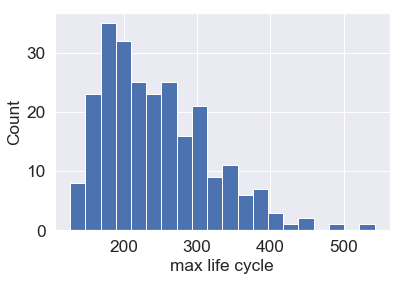

In [22]:
# Repeat for the other training data sets
train_FD002[['engine_id', 'rul']].groupby('engine_id').apply(np.max)["rul"].hist(bins=20)
plt.xlabel("max life cycle")
plt.ylabel("Count")
plt.show()

train_FD003[['engine_id', 'rul']].groupby('engine_id').apply(np.max)["rul"].hist(bins=20)
plt.xlabel("max life cycle")
plt.ylabel("Count")
plt.show()

train_FD004[['engine_id', 'rul']].groupby('engine_id').apply(np.max)["rul"].hist(bins=20)
plt.xlabel("max life cycle")
plt.ylabel("Count")
plt.show()

Though qualitatively still related, there is clearly a difference in distribution of max. life cycle in the four training data sets. We prepare box plots as another simple form of visualization to get an overview of the samples.

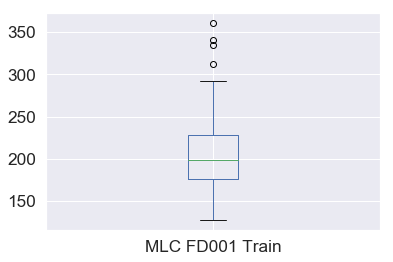

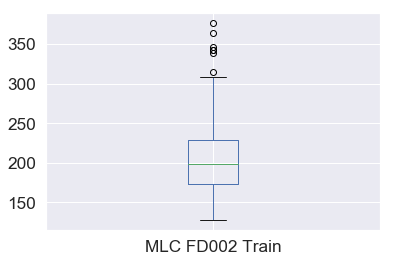

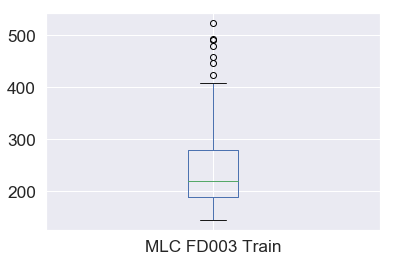

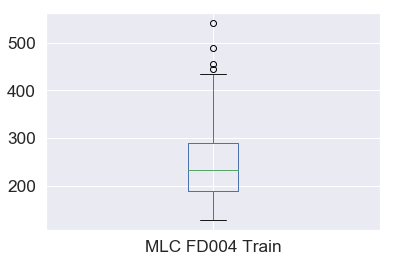

In [23]:
rul001 = train_FD001[['engine_id', 'rul']].groupby('engine_id').apply(np.max)['rul'].rename('MLC FD001 Train')
rul001.plot(kind='box')
plt.show()

rul002 = train_FD002[['engine_id', 'rul']].groupby('engine_id').apply(np.max)['rul'].rename('MLC FD002 Train')
rul002.plot(kind='box')
plt.show()

rul003 = train_FD003[['engine_id', 'rul']].groupby('engine_id').apply(np.max)['rul'].rename('MLC FD003 Train')
rul003.plot(kind='box')
plt.show()

rul004 = train_FD004[['engine_id', 'rul']].groupby('engine_id').apply(np.max)['rul'].rename('MLC FD004 Train')
rul004.plot(kind='box')
plt.show()

As we see from the box plots, the mean of max. life cycle values of engines in the data sets varies. While FD001 and 002 train feature a mean of 200, the other ones show significantly larger means. All sets feature outliers, but especially FD003 and 004 train include some that are meaningfully about 400.

Overall, we gain the insight that the training data sets are similar but we might expect the models applied on each most successfully to likely differ regarding their hyper parameters.

# Modeling the FD001 Data Set


## I. 'Naive' Approach

First, we try to model the regression problem by only looking at a single input vector at a time. We call this the 'naive' approach for now.

We will focus on three regression models for now: A Random Forest approach, a linear Lasso model and finally a Multilayer Perceptron regressor.

For each approach, hyper parameter tuning was performed using a combination of automated (grid search) and manual (estimation from experience, comparison) techniques as is described in the following.

First, the training and test data is set up:

In [24]:
# Prepare the data and normalization
train_y = train_FD001['rul']
features = train_FD001.columns.drop(['engine_id', 'cycle', 'rul'])
train_x = train_FD001[features]
test_x = test_FD001[features]


# z score normalization
mean = train_x.mean()
std = train_x.std()
std.replace(0, 1, inplace=True)

train_x = (train_x - mean) / std
test_x = (test_x - mean) / std

from sklearn.utils import shuffle
x, y = shuffle(train_x, train_y)

Here only the values at each time point (cycle) are used to predict the RUL. Temporal relationship is ignored.

### 1. Random Forest

We first take a look at a RF regressor with default hyper parameters. 

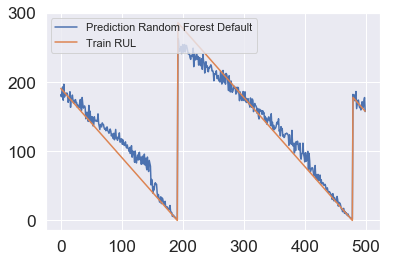

In [25]:
# Random Forest with default Hyper parameters
rf_model = RandomForestRegressor()
rf_model.fit(x,y)
rf_prediction = rf_model.predict(train_x)

plt.plot(rf_prediction[:500], label="Prediction Random Forest Default")
plt.plot(train_FD001["rul"][:500], label="Train RUL")
plt.legend(loc="upper left")
plt.show()

From experience we know that Random Forest models can be easily tuned by looking at the n_estimators (the number of estimators) and max_features (the number of features to include at most) parameters in scikit.

A grid search was performed using the following approach:

In [26]:
# (No need to run in-line in the notebook, just for exlanation)
# param_grid = {'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 17, 20, 25, 26, 27, 30, 35, 40]}

# search = GridSearchCV(rf_model, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=5, n_jobs=-1)
# search.fit(x,y)

# >>> Best result: max_features=3

Let’s use that result to create a better RF regressor than the default one. Generally, a higher number of regressors is better, we will use n_estimators=500 as a trade-off between model fit time and quality of the result.

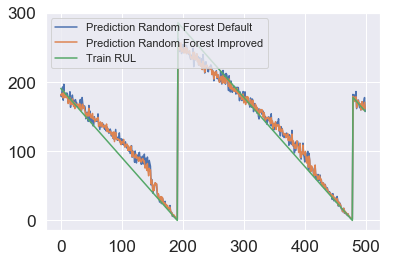

In [27]:
rf_model_impr = RandomForestRegressor(n_estimators=500, max_features=3)  # 3 was best, based on grid search
rf_model_impr.fit(x,y)
rf_prediction_impr = rf_model_impr.predict(train_x)

plt.plot(rf_prediction[:500], label="Prediction Random Forest Default")
plt.plot(rf_prediction_impr[:500], label="Prediction Random Forest Improved")
plt.plot(train_FD001["rul"][:500], label="Train RUL")
plt.legend(loc="upper left")
plt.show()

Visually we can already see small differences based on the new hyper parameters, but only at the evaluation step can we see how much better the improved RF model performs overall. 

### 2. Lasso (CV) Model

Our next candidate model is a linear Lasso approach, wich is directly provided by scikit with cross validation and therefore convenient for higher-dimensional data sets.

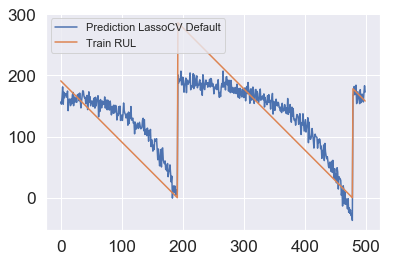

In [28]:
# Lasso model with default Hyper parameters
ls_model = LassoCV()
ls_model.fit(x,y)
ls_prediction = ls_model.predict(train_x)

plt.plot(ls_prediction[:500], label="Prediction LassoCV Default")
plt.plot(train_FD001["rul"][:500], label="Train RUL")
plt.legend(loc="upper left")
plt.show()

For Lasso models, we can say from experience that the most interesting parameter to tune is genereally alpha. We additionally perform manually guided best alpha search using the built-in cross validation in LassoCV as follows:

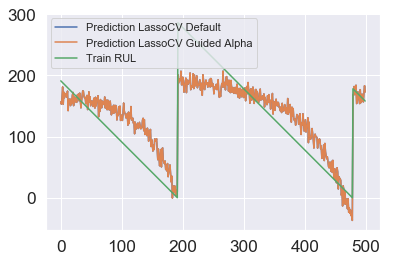

In [29]:
ls_model_alt = LassoCV(alphas=[0.05, 0.2, 0.5, 0.6, 0.8, 1.0, 1.4, 1.8, 2.2, 2.6, 3.0, 4.0, 6.0])
ls_model_alt.fit(x,y)
ls_alt_prediction = ls_model_alt.predict(train_x)

plt.plot(ls_prediction[:500], label="Prediction LassoCV Default")
plt.plot(ls_alt_prediction[:500], label="Prediction LassoCV Guided Alpha")
plt.plot(train_FD001["rul"][:500], label="Train RUL")
plt.legend(loc="upper left")
plt.show()

As is directly visible from the plot, manually guiding the alpha values to be used during cross-validation didn’t lead to notable differences, the model characteristics are very similar.

### 3. Multilayer Perceptron Regressor

Finnaly, we use the MLPRegressor provided by scikit to model the problem using a neural net model. We first use the default net with one hidden layer of 100 units.

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


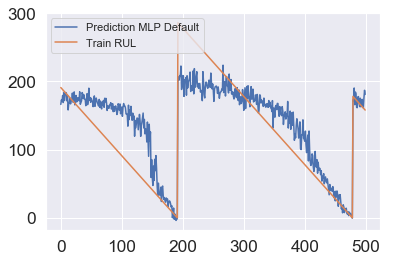

In [30]:
mlp_model = MLPRegressor()
mlp_model.fit(x,y)
mlp_prediction = mlp_model.predict(train_x)

plt.plot(mlp_prediction[:500], label="Prediction MLP Default")
plt.plot(train_FD001["rul"][:500], label="Train RUL")
plt.legend(loc="upper left")
plt.show()

We get a warning that the model with default hyper parameters didn’t converge, but at first sight, the result looks promising and we continue our search for a MLP model.

First, we look at different general hyper parameters to tune using grid search:
- The activation function used
- The solver optimizing our MLP
- The size of the hidden layer

In [31]:
# (No need to run in-line in the notebook, just for exlanation)
# param_grid = [
#         {
#             'activation' : ['identity', 'logistic', 'tanh', 'relu'],
#             'solver' : ['lbfgs', 'sgd', 'adam'],
#             'hidden_layer_sizes': [
#              (10,),(20,),(30,),(40,),(50,),(60,),(70,),(80,),(90,),(100,),(110,), (120,),(130,),(140,)
#              ]
#         }
#        ]

# >>> Best result: relu, 120, adam

The grid search confirmes that the default hyper parameters are well chosen in terms of the ones investigated above. Therefore, we take a look at other hyper parameters now:

In [32]:
# (No need to run in-line in the notebook, just for exlanation)
# param_grid = [
#     {'learning_rate_init': [0.01, 0.001, 0.0001, 0.00001],
#     'max_iter': [100, 300, 600, 1000]}
# ]

# >>> Best results: 0.001, 100

Grid search indicated that under these circumstances, even 100 iterations at a constant learning rate of 0.001 should be suffcient. We create this new model in the following: 

In [33]:
mlp_model_impr = MLPRegressor(learning_rate='constant', learning_rate_init=0.001, max_iter=100)
mlp_model_impr.fit(x,y)
mlp_impr_prediction = mlp_model.predict(train_x)

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### 5. Preliminary Model Comparison

Before we evaluate models on the test data set, we take a look at how they compare to each other in terms of modelling the traning data well.

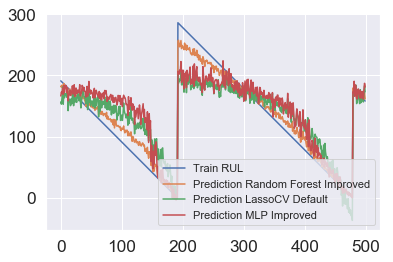

In [34]:
plt.plot(train_FD001["rul"][:500], label="Train RUL")
plt.plot(rf_prediction_impr[:500], label="Prediction Random Forest Improved")
plt.plot(ls_prediction[:500], label="Prediction LassoCV Default")
plt.plot(mlp_impr_prediction[:500], label="Prediction MLP Improved")
plt.legend(loc="lower right")
plt.show()

**All 'naive' models seem to perform regression on the training data at least on a basic level, but we can only evaluate their true performance using a test data set.**

## Evaluation on FD001 Test Set

In [35]:
# Since only the value at one time point is used, it can be seen that a lot of data in the test set is not used

test_x['engine_id'] = test_FD001['engine_id']
test_input = []
for id in test_x['engine_id'].unique():
    test_input.append(test_x[test_x['engine_id']==id].iloc[-1,:-1].values)

test_input = np.array(test_input)

### 1. Random Forest

In [36]:
rf_test_prediction = rf_model_impr.predict(test_input)
rf_rmse = np.sqrt(mean_squared_error(rf_test_prediction, RUL_FD001.values.reshape(-1)))

print("The RMSE of random forest on test dataset FD001 is ", rf_rmse)

The RMSE of random forest on test dataset FD001 is  31.585170497561034


### 2. Lasso

In [37]:
ls_test_prediction = ls_model.predict(test_input)
ls_rmse = np.sqrt(mean_squared_error(ls_test_prediction, RUL_FD001.values.reshape(-1)))

print("The RMSE of Lasso model on test dataset FD001 is ", ls_rmse)

The RMSE of Lasso model on test dataset FD001 is  32.01253941579562


### 3. Multilayer Perceptron Regressor

In [38]:
mlp_impr_prediction = mlp_model_impr.predict(test_input)
mlp_rmse = np.sqrt(mean_squared_error(mlp_impr_prediction, RUL_FD001.values.reshape(-1)))

print("The RMSE of MLP model on test dataset FD001 is ", mlp_rmse)

The RMSE of MLP model on test dataset FD001 is  31.542476175735008


**Of these 'naive' results, all models perform similarly on the test set. However, none of the approaches (i.e. only looking at a single input sample at a time) leads to acceptable results, with the RSME remaining rather large.**

Therefore, we continue the modelling process using another concept that is rooted in the time series nature of the data set present: A sliding window based approach.

## II. Sliding Window Approach

As we have seen, looking at a slingle input at a time does not work well. We instead try a sliding window approach, i.e. not only looking at a single input but including its k - 1 previous inputs as well, where k is a (typically small) integer variable to be explored later on.

First, we set up a function to generate sliding window data sets of an arbitrary size k and constant stride 1. To achieve this, we append columns to the data set that are suffix with ...-tminusX where X is in 1..k-1. Missing input values at the beginnig of the sliding window data set are set to zero.

In order to achieve efficient transformation of the data sets, we make use of pandas join operations of individual data frames: 

In [39]:
def sliding_window_data(df_in, k):
    df_out = df_in.copy() 
    df_master_copy = df_in.copy()

    for i in reversed(range(k - 1)):
        df_copy = df_master_copy.copy()

        to_delete = k - i - 1
        
        # Delete last x rows in the local copy
        df_copy = df_copy[:-to_delete]

        # Insert x empty rows at the beginning
        for j in range(to_delete):
            df_copy = df_copy.append(pd.Series(name='0', dtype='float64'))
            df_copy = df_copy.shift(periods=1)
            df_copy = df_copy.reset_index(drop=True)

        # Replace NaN values with zero
        df_copy = df_copy.fillna(0)
        
        # Rename columns: Use original name and add ...-tminusX
        new_cols = []
        for col_orig in df_copy.columns:
            new_cols.append(col_orig + "-tminus" + str(to_delete))

        df_copy.columns = new_cols

        # Append columns to result data frame
        df_out = df_copy.join(df_out)

    return df_out

Now let’s use the new function to create a sliding window test and validation set, based on FD0001. We use k = 20 to start out, i.e. sliding window size of 20 and take a look at the new data set:

In [40]:
train_x_sw20 = sliding_window_data(train_x, 20)

if 'engine_id' in test_x:
    test_x = test_x.drop(['engine_id'], axis=1)  # Don't forget to drop the column added for testing previously!
test_x_sw20 = sliding_window_data(test_x, 20)

print("-> Shapes of the new data frames:", train_x_sw20.shape, test_x_sw20.shape)

train_x_sw20.head()

-> Shapes of the new data frames: (20631, 480) (13096, 480)


,setting1-tminus19,setting2-tminus19,setting3-tminus19,s1-tminus19,s2-tminus19,s3-tminus19,s4-tminus19,s5-tminus19,s6-tminus19,s7-tminus19,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.334254,-1.058865,-0.269065,-0.603801,0.999976,-0.781691,0.0,0.0,1.348460,1.194398
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.174871,-0.363637,-0.642829,-0.275845,0.999976,-0.781691,0.0,0.0,1.016503,1.236892
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.364688,-0.919819,-0.551616,-0.649128,0.999976,-2.073044,0.0,0.0,0.739873,0.503411
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.961255,-0.224592,-0.520163,-1.971617,0.999976,-0.781691,0.0,0.0,0.352590,0.777773
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.052846,-0.780774,-0.521736,-0.339837,0.999976,-0.136014,0.0,0.0,0.463242,1.059526


In [41]:
train_x_sw20.tail()

,setting1-tminus19,setting2-tminus19,setting3-tminus19,s1-tminus19,s2-tminus19,s3-tminus19,s4-tminus19,s5-tminus19,s6-tminus19,s7-tminus19,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
20626,-0.498845,-1.714145,0.0,0.999976,1.317992,0.439866,1.108394,0.999976,0.14168,-0.754397,...,-2.607906,2.278227,-0.322534,1.425260,0.999976,2.446692,0.0,0.0,-1.805129,-2.921042
20627,0.232646,-1.031695,0.0,0.999976,0.598069,0.697566,1.528366,0.999976,0.14168,-1.703451,...,-2.350298,1.722045,-0.380198,1.913194,0.999976,1.155339,0.0,0.0,-2.856326,-1.203735
20628,0.918419,1.356877,0.0,0.999976,1.078018,1.441309,1.667246,0.999976,0.14168,-1.737346,...,-1.902872,2.000136,-0.141680,3.265013,0.999976,3.092369,0.0,0.0,-2.081760,-3.292402
20629,-0.453127,0.333203,0.0,0.999976,1.917929,0.890026,0.835079,0.999976,0.14168,-1.488784,...,-2.363856,1.861090,-0.233942,2.579771,0.999976,1.155339,0.0,0.0,-2.911652,-2.085021
20630,1.101292,-1.714145,0.0,0.999976,1.138012,1.191764,0.632871,0.999976,0.14168,-1.274117,...,-2.865515,2.278227,-0.336688,1.638564,0.999976,1.801015,0.0,0.0,-2.469043,-2.194027


As expected, the first rows contain many zero values due to the padding strategy applied, but the temporaly shifted data is fully present in the rows starting out from the 20th row and down.

We also prepare sliding window data sets with k = 50.

In [42]:
train_x_sw50 = sliding_window_data(train_x, 50)
test_x_sw50 = sliding_window_data(test_x, 50)
print("-> Shapes of the new data frames:", train_x_sw50.shape, test_x_sw50.shape)
print("Memory usage:", round(test_x_sw50.memory_usage(index=True).sum() / (1024 ** 2), 0), "MB")

x_sw20, y_sw20 = shuffle(train_x_sw20, train_y)
x_sw50, y_sw50 = shuffle(train_x_sw50, train_y)

-> Shapes of the new data frames: (20631, 1200) (13096, 1200)
Memory usage: 120.0 MB


### (2.) Lasso Model

We use a linear LassoCV model (previously the second model applied) with built-in cross-validation as a first simple approach on our new sliding window data sets, to see which results we can achieve.

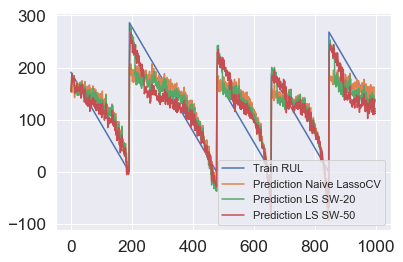

In [43]:
ls_model_sw20 = LassoCV()
ls_model_sw20.fit(x_sw20, y_sw20)
ls_prediction_sw20 = ls_model_sw20.predict(train_x_sw20)

ls_model_sw50 = LassoCV()
ls_model_sw50.fit(x_sw50, y_sw50)
ls_prediction_sw50 = ls_model_sw50.predict(train_x_sw50)

plt.plot(train_FD001["rul"][:1000], label="Train RUL")
plt.plot(ls_prediction[:1000], label="Prediction Naive LassoCV")
plt.plot(ls_prediction_sw20[:1000], label="Prediction LS SW-20")
plt.plot(ls_prediction_sw50[:1000], label="Prediction LS SW-50")
plt.legend(loc="lower right")
plt.show()

We can immediately observe qualitative differences in the fitting characteristics between the navive Lasso model and the two sliding window approaches.

Let’s see what this relates to on the validation data set:

In [44]:
# Sliding window k=20 model
test_x_sw20['engine_id'] = test_FD001['engine_id']
test_input = []
for id in test_x_sw20['engine_id'].unique():
    test_input.append(test_x_sw20[test_x_sw20['engine_id']==id].iloc[-1,:-1].values)

test_input = np.array(test_input)

ls_test_prediction = ls_model_sw20.predict(test_input)
ls_rmse = np.sqrt(mean_squared_error(ls_test_prediction, RUL_FD001.values.reshape(-1)))
print("The RMSE of Lasso model SW-20 on test dataset FD001 is ", ls_rmse)

# Sliding window k=50 model
test_x_sw50['engine_id'] = test_FD001['engine_id']
test_input = []
for id in test_x_sw50['engine_id'].unique():
    test_input.append(test_x_sw50[test_x_sw50['engine_id']==id].iloc[-1,:-1].values)

test_input = np.array(test_input)

ls_test_prediction = ls_model_sw50.predict(test_input)
ls_rmse = np.sqrt(mean_squared_error(ls_test_prediction, RUL_FD001.values.reshape(-1)))
print("The RMSE of Lasso model SW-50 on test dataset FD001 is ", ls_rmse)

The RMSE of Lasso model SW-20 on test dataset FD001 is  27.34411723786387
The RMSE of Lasso model SW-50 on test dataset FD001 is  21.31314614174973


We can immediatly observe that a larger sliding window for the lasso model leads to better results on the evaluation data. Therefore we can assume that likely, for the other models this holds true as well.
Based on this assumption, we will only train models with k = 50 from now on. We will not use larger sliding windows, as the memory needs and transform times are inconvenient in context of this notebook document, but it was  observed that generally larger sliding windows result in better results when evaluating the models. 

### 1. Random Forest

Now let’s take a look at the random forest again. With grid search, max_features = 200 was determined to be a well suited parameter and n_estimators = 500 is again used as a trade-off between computing time available and quality of the fit.

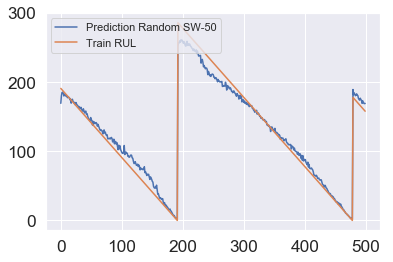

The RMSE of RF model SW-50 on test dataset FD001 is  21.5142828279262


In [45]:
rf_model_sw50 = RandomForestRegressor(n_estimators=250, max_features=75)
rf_model_sw50.fit(x_sw50, y_sw50)
rf_prediction = rf_model_sw50.predict(train_x_sw50)

plt.plot(rf_prediction[:500], label="Prediction Random SW-50")
plt.plot(train_FD001["rul"][:500], label="Train RUL")
plt.legend(loc="upper left")
plt.show()

# Evaluate
rf_test_prediction = rf_model_sw50.predict(test_input)
rf_rmse = np.sqrt(mean_squared_error(rf_test_prediction, RUL_FD001.values.reshape(-1)))
print("The RMSE of RF model SW-50 on test dataset FD001 is ", rf_rmse)

### 3. Multilayer Perceptron Regressor

For the MLP regressor with sliding window k=50, again hyper parameters were chosen using a grid search approach.

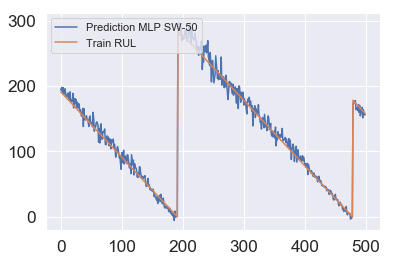

The RMSE of MLP model SW-50 on test dataset FD001 is  31.975968566821848


In [46]:
mlp_model_sw50 = MLPRegressor(hidden_layer_sizes=800, learning_rate='constant', learning_rate_init=0.01, max_iter=200)
mlp_model_sw50.fit(x_sw50, y_sw50)
mlp_prediction = mlp_model_sw50.predict(train_x_sw50)

plt.plot(mlp_prediction[:500], label="Prediction MLP SW-50")
plt.plot(train_FD001["rul"][:500], label="Train RUL")
plt.legend(loc="upper left")
plt.show()

# Evaluate
mlp_test_prediction = mlp_model_sw50.predict(test_input)
mlp_rmse = np.sqrt(mean_squared_error(mlp_test_prediction, RUL_FD001.values.reshape(-1)))
print("The RMSE of MLP model SW-50 on test dataset FD001 is ", mlp_rmse)

## Result on FD001

**On evaluation data set FD001 the sliding window (k=50) Random Forest worked best with RSME about 21.01 on average.**

# Modeling the FD002 Data Set

Now we are going to repeat the process from FD001 on the other data sets. Because sliding window beat the 'naive' approach by far, we are only going to use sliding window regression going forward.

For each model, grid seach was used to determine the best hyper parameters.

Let’s first set up the data:

In [47]:
# Prepare the data and normalization
train_y = train_FD002['rul']
features = train_FD002.columns.drop(['engine_id', 'cycle', 'rul'])
train_x = train_FD002[features]
test_x = test_FD002[features]

# z score normalization
mean = train_x.mean()
std = train_x.std()
std.replace(0, 1, inplace=True)

train_x = (train_x - mean) / std
test_x = (test_x - mean) / std

from sklearn.utils import shuffle
x, y = shuffle(train_x, train_y)

# Create sliding window data
train_x_sw50 = sliding_window_data(train_x, 50)
test_x_sw50 = sliding_window_data(test_x, 50)

x_sw50, y_sw50 = shuffle(train_x_sw50, train_y)

# Create test set
test_x_sw50['engine_id'] = test_FD002['engine_id']
test_input = []
for id in test_x_sw50['engine_id'].unique():
    test_input.append(test_x_sw50[test_x_sw50['engine_id']==id].iloc[-1,:-1].values)

## 1. Random Forest

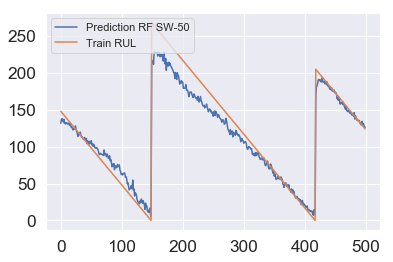

The RMSE of RF model SW-50 on test dataset FD002 is  29.105560434139182


In [48]:
rf_model_FD002_sw50 = RandomForestRegressor(n_estimators=250, max_features=75)
rf_model_FD002_sw50.fit(x_sw50, y_sw50)
rf_prediction = rf_model_FD002_sw50.predict(train_x_sw50)

plt.plot(rf_prediction[:500], label="Prediction RF SW-50")
plt.plot(train_FD002["rul"][:500], label="Train RUL")
plt.legend(loc="upper left")
plt.show()

# Evaluate
rf_test_prediction = rf_model_FD002_sw50.predict(test_input)
rf_rmse = np.sqrt(mean_squared_error(rf_test_prediction, RUL_FD002.values.reshape(-1)))
print("The RMSE of RF model SW-50 on test dataset FD002 is ", rf_rmse)

## 2. Lasso Model

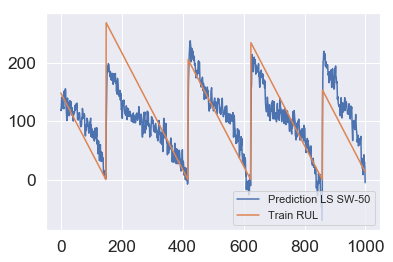

The RMSE of Lasso model SW-50 on test dataset FD002 is  29.604581537326613


In [49]:
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning) # Ignore convergence warnings, our number of iterations is sufficient

ls_model_002_sw50 = LassoCV()
ls_model_002_sw50.fit(x_sw50, y_sw50)
ls_prediction_sw50 = ls_model_002_sw50.predict(train_x_sw50)

plt.plot(ls_prediction_sw50[:1000], label="Prediction LS SW-50")
plt.plot(train_FD002["rul"][:1000], label="Train RUL")
plt.legend(loc="lower right")
plt.show()

# Evaluate
ls_test_prediction = ls_model_002_sw50.predict(test_input)
ls_rmse = np.sqrt(mean_squared_error(ls_test_prediction, RUL_FD002.values.reshape(-1)))
print("The RMSE of Lasso model SW-50 on test dataset FD002 is ", ls_rmse)

## 3. Multilayer Perceptron Regressor

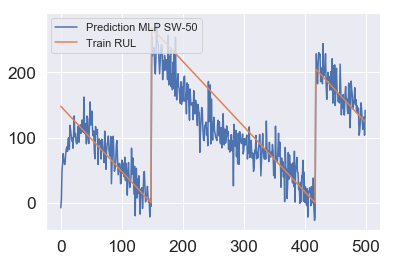

The RMSE of MLP model SW-50 on test dataset FD002 is  42.390094120778905


In [51]:
mlp_model_002_sw50 = MLPRegressor(hidden_layer_sizes=600, learning_rate='constant', learning_rate_init=0.01, max_iter=100)
mlp_model_002_sw50.fit(x_sw50, y_sw50)
mlp_prediction = mlp_model_002_sw50.predict(train_x_sw50)

plt.plot(mlp_prediction[:500], label="Prediction MLP SW-50")
plt.plot(train_FD002["rul"][:500], label="Train RUL")
plt.legend(loc="upper left")
plt.show()

# Evaluate
mlp_test_prediction = mlp_model_002_sw50.predict(test_input)
mlp_rmse = np.sqrt(mean_squared_error(mlp_test_prediction, RUL_FD002.values.reshape(-1)))
print("The RMSE of MLP model SW-50 on test dataset FD002 is ", mlp_rmse)

## Result on FD002

**On evaluation data set FD002 the sliding window (k=50) Random Forest worked best again, but Lasso shows comparable performance on the evaluation data set.**

# Modeling the FD003 Data Set

Again, first set up the data to work on:

In [ ]:
# Prepare the data and normalization
train_y = train_FD003['rul']
features = train_FD003.columns.drop(['engine_id', 'cycle', 'rul'])
train_x = train_FD003[features]
test_x = test_FD003[features]

# z score normalization
mean = train_x.mean()
std = train_x.std()
std.replace(0, 1, inplace=True)

train_x = (train_x - mean) / std
test_x = (test_x - mean) / std

from sklearn.utils import shuffle
x, y = shuffle(train_x, train_y)

# Create sliding window data
train_x_sw50 = sliding_window_data(train_x, 50)
test_x_sw50 = sliding_window_data(test_x, 50)

x_sw50, y_sw50 = shuffle(train_x_sw50, train_y)

# Create test set
test_x_sw50['engine_id'] = test_FD003['engine_id']
test_input = []
for id in test_x_sw50['engine_id'].unique():
    test_input.append(test_x_sw50[test_x_sw50['engine_id']==id].iloc[-1,:-1].values)

## 1. Random Forest

In [ ]:
rf_model_FD003_sw50 = RandomForestRegressor(n_estimators=250, max_features=75)
rf_model_FD003_sw50.fit(x_sw50, y_sw50)
rf_prediction = rf_model_FD003_sw50.predict(train_x_sw50)

plt.plot(rf_prediction[:500], label="Prediction Random SW-50")
plt.plot(train_FD003["rul"][:500], label="Train RUL")
plt.legend(loc="upper left")
plt.show()

# Evaluate
rf_test_prediction = rf_model_FD003_sw50.predict(test_input)
rf_rmse = np.sqrt(mean_squared_error(rf_test_prediction, RUL_FD003.values.reshape(-1)))
print("The RMSE of RF model SW-50 on test dataset FD003 is ", rf_rmse)

## 2. Lasso Model

In [ ]:
ls_model_003_sw50 = LassoCV()
ls_model_003_sw50.fit(x_sw50, y_sw50)
ls_prediction_sw50 = ls_model_003_sw50.predict(train_x_sw50)

plt.plot(ls_prediction_sw50[:1000], label="Prediction LS SW-50")
plt.plot(train_FD003["rul"][:1000], label="Train RUL")
plt.legend(loc="lower right")
plt.show()

# Evaluate
ls_test_prediction = ls_model_003_sw50.predict(test_input)
ls_rmse = np.sqrt(mean_squared_error(ls_test_prediction, RUL_FD003.values.reshape(-1)))
print("The RMSE of Lasso model SW-50 on test dataset FD003 is ", ls_rmse)

## 3. Multilayer Perceptron Regressor

In [ ]:
mlp_model_003_sw50 = MLPRegressor(hidden_layer_sizes=800, learning_rate='constant', learning_rate_init=0.01, max_iter=200)
mlp_model_003_sw50.fit(x_sw50, y_sw50)
mlp_prediction = mlp_model_003_sw50.predict(train_x_sw50)

plt.plot(mlp_prediction[:500], label="Prediction MLP SW-50")
plt.plot(train_FD003["rul"][:500], label="Train RUL")
plt.legend(loc="upper left")
plt.show()

# Evaluate
mlp_test_prediction = mlp_model_003_sw50.predict(test_input)
mlp_rmse = np.sqrt(mean_squared_error(mlp_test_prediction, RUL_FD003.values.reshape(-1)))
print("The RMSE of MLP model SW-50 on test dataset FD003 is ", mlp_rmse)

## Result on FD003

**On evaluation data set FD003 the sliding window (k=50) Random Forest shows the best performance on average.**

# Modeling the FD004 Data Set

As before, we first set up the data:

In [ ]:
# Prepare the data and normalization
train_y = train_FD004['rul']
features = train_FD004.columns.drop(['engine_id', 'cycle', 'rul'])
train_x = train_FD004[features]
test_x = test_FD004[features]

# z score normalization
mean = train_x.mean()
std = train_x.std()
std.replace(0, 1, inplace=True)

train_x = (train_x - mean) / std
test_x = (test_x - mean) / std

from sklearn.utils import shuffle
x, y = shuffle(train_x, train_y)

# Create sliding window data
train_x_sw50 = sliding_window_data(train_x, 50)
test_x_sw50 = sliding_window_data(test_x, 50)

x_sw50, y_sw50 = shuffle(train_x_sw50, train_y)

# Create test set
test_x_sw50['engine_id'] = test_FD004['engine_id']
test_input = []
for id in test_x_sw50['engine_id'].unique():
    test_input.append(test_x_sw50[test_x_sw50['engine_id']==id].iloc[-1,:-1].values)

## 1. Random Forest

In [ ]:
rf_model_FD004_sw50 = RandomForestRegressor(n_estimators=250, max_features=75)
rf_model_FD004_sw50.fit(x_sw50, y_sw50)
rf_prediction = rf_model_FD004_sw50.predict(train_x_sw50)

plt.plot(rf_prediction[:500], label="Prediction Random SW-50")
plt.plot(train_FD004["rul"][:500], label="Train RUL")
plt.legend(loc="upper left")
plt.show()

# Evaluate
rf_test_prediction = rf_model_FD004_sw50.predict(test_input)
rf_rmse = np.sqrt(mean_squared_error(rf_test_prediction, RUL_FD004.values.reshape(-1)))
print("The RMSE of RF model SW-50 on test dataset FD004 is ", rf_rmse)

## 2. Lasso Model

In [ ]:
ls_model_004_sw50 = LassoCV()
ls_model_004_sw50.fit(x_sw50, y_sw50)
ls_prediction_sw50 = ls_model_004_sw50.predict(train_x_sw50)

plt.plot(ls_prediction_sw50[:1000], label="Prediction LS SW-50")
plt.plot(train_FD004["rul"][:1000], label="Train RUL")
plt.legend(loc="lower right")
plt.show()

# Evaluate
ls_test_prediction = ls_model_004_sw50.predict(test_input)
ls_rmse = np.sqrt(mean_squared_error(ls_test_prediction, RUL_FD004.values.reshape(-1)))
print("The RMSE of Lasso model SW-50 on test dataset FD004 is ", ls_rmse)

## 3. Multilayer Perceptron Regressor

In [ ]:
mlp_model_004_sw50 = MLPRegressor(hidden_layer_sizes=800, learning_rate='constant', learning_rate_init=0.01, max_iter=200)
mlp_model_004_sw50.fit(x_sw50, y_sw50)
mlp_prediction = mlp_model_004_sw50.predict(train_x_sw50)

plt.plot(mlp_prediction[:500], label="Prediction MLP SW-50")
plt.plot(train_FD004["rul"][:500], label="Train RUL")
plt.legend(loc="upper left")
plt.show()

# Evaluate
mlp_test_prediction = mlp_model_004_sw50.predict(test_input)
mlp_rmse = np.sqrt(mean_squared_error(mlp_test_prediction, RUL_FD004.values.reshape(-1)))
print("The RMSE of MLP model SW-50 on test dataset FD004 is ", mlp_rmse)

## Result on FD004

**On data evaluation data set FD004 the sliding window (k=50) Random Forest approach worked best on average.**

# Conclusion

We have determined that modelling the regression problem was most successfully done using the sliding window approach. As a trade-off between quality of modelling and the computing time and memory required, we have chose to work with sliding windows of size k = 50 at most. Genereally, we assume that larger sliding window sizes would however result in even better perfromance the evaluation data, as times seqeunces usually are well suited to this.
At each step of modelling, we applied the useful capabilities of scikit grid search and cross validation to come up with well suited parameters to speed up hyper parameter selection.

Overview of the best models on the evaluation data sets:

| FD001 | FD002 | FD003 | FD004 |
|:-----:|:-----:|:-----:|:-----:|
|RF-SW50|RF-SW50|RF-SW50|RF-SW50|

Unexpectedly, the RF regressor worked best on averge on all data sets, but the linear lasso model was close. The simple MLP regressor couldn’t deliver results as good as we had hoped, as it was most likely not possible to achieve better performance without testing more complex architectures.

A practical limitation were the extensive memory demands of larger sliding windows, as implemented for this task and long fitting times, which limited the number of models to try out given the time available.

The development of a solution to create sliding window data sets using the pandas join operation was the essential step in enabling sliding window regressors for this task. This was challenging to make efficient in terms of transformation memory demands and transform times.

In General, we could learn much from the previous tasks of task set 1 and applied them all in task 9, regarding data set exploratin, visualization, model selection, hyper parameter tuning and of course evaluation. In the future, we would maybe also want to apply composite regression models to this problem that are possible to implement using scikit.